In [357]:
#import tensorflow.keras
import os
from os import listdir
from os.path import isdir, join
import numpy as np
from keras import layers, models, metrics
from subprocess import check_output
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv3D,MaxPooling3D,Dense,Flatten,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [358]:
feature_sets_path  = os.getcwd()
filename = 'all_targets_1629_5369'
feature_sets_filename = filename + '.npz'
model_filename = filename + '_8_8_8_16_16_32.h5'
#feature_sets_filename = 'all_targets_987_5135_2_classes_2023_9_2_7-48.npz'
#model_filename = 'all_targets_987_5135_2_classes_2023_9_2_7-48_minus_CNN01.h5'

In [359]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print('features :',feature_sets.files)

features : ['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [360]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [361]:
# Look at tensor dimensions
print('training input shape :',x_train.shape)
print('validation input shape :',x_val.shape)
print('test input shape :',x_test.shape)

training input shape : (20828, 64, 4)
validation input shape : (4445, 64, 4)
test input shape : (4445, 64, 4)


In [362]:
# Sample shape
NUMBER_ROWS = 127
NUMBER_COlUMNS = 64
DEPTH = 4

In [363]:
# CNN for TF expects (batch (lote), height, width, channels)
# So we reshape the input tensors with a "color" channel of ''

x_train = x_train.reshape(int(x_train.shape[0]/(NUMBER_ROWS)),
                          NUMBER_ROWS,
                          NUMBER_COlUMNS,
                          DEPTH,
                          1)
x_val = x_val.reshape(int(x_val.shape[0]/(NUMBER_ROWS)),
                      NUMBER_ROWS,
                      NUMBER_COlUMNS,
                      DEPTH,
                      1)
x_test = x_test.reshape(int(x_test.shape[0]/(NUMBER_ROWS)),
                        NUMBER_ROWS,
                        NUMBER_COlUMNS,
                        DEPTH,
                        1)

print('number of training samples :',x_train.shape[0])
print('number of validation samples :',x_val.shape[0])
print('number of test samples :',x_test.shape[0])

number of training samples : 164
number of validation samples : 35
number of test samples : 35


In [364]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print('sample shape :',sample_shape)

sample shape : (127, 64, 4, 1)


In [365]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()

# Convolution filters
model.add(layers.Conv3D(filters=8, kernel_size=(3,3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', input_shape=sample_shape, name = 'Conv3D_layer1'))
model.add(layers.MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer1'))

model.add(Conv3D(filters=8, kernel_size=(3,3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv3D_layer2'))
model.add(MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer2'))

model.add(Conv3D(filters=8, kernel_size=(3,3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv3D_layer3'))
model.add(MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer3'))

# Classifier
model.add(Flatten())
model.add(Dense(128, kernel_initializer='random_normal', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, kernel_initializer='random_normal', activation='relu'))
model.add(Dropout(0.6))


# Check Number of Classes Before Training
model.add(Dense(2, activation='softmax'))

# Display model
model.layers
model.summary()

c:\Users\Iman\Desktop\Stage\code\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv3D_layer1 (Conv3D)          │ (None, 127, 64, 4, 8)  │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer1 (MaxPooling3D)   │ (None, 63, 32, 4, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3D_layer2 (Conv3D)          │ (None, 63, 32, 4, 8)   │         1,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer2 (MaxPooling3D)   │ (None, 31, 16, 4, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3D_layer3 (Conv3D)          │ (None, 31, 16, 4, 8)   │         1,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer3 (MaxPooling3D)   │ (None, 15, 8, 4, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499,538 (1.91 MB)

 Trainable params: 499,538 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [366]:
# PatientEearly Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [367]:
# Add training parameters to model
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='Adam', #SGD, RMSProp, Adam, nadam
             loss_weights=0.1,
             metrics=['accuracy'])

In [368]:
# Train
history = model.fit(x_train,
                   y_train,
                   epochs=500,
                   batch_size=256,
                   validation_data=(x_val,y_val),
                    callbacks = [es])

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4756 - loss: 0.0694 - val_accuracy: 0.3714 - val_loss: 0.0695
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - accuracy: 0.4939 - loss: 0.0694 - val_accuracy: 0.9429 - val_loss: 0.0690
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step - accuracy: 0.5549 - loss: 0.0690 - val_accuracy: 1.0000 - val_loss: 0.0688
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - accuracy: 0.5793 - loss: 0.0688 - val_accuracy: 0.6286 - val_loss: 0.0684
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step - accuracy: 0.5488 - loss: 0.0692 - val_accuracy: 0.6286 - val_loss: 0.0682
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step - accuracy: 0.5244 - loss: 0.0685 - val_accuracy: 0.6286 - val_loss: 0.0675
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step - accuracy: 0.5305 - loss: 0.0693 - val_accuracy: 0.6286 - val_loss: 0.0669
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step - accuracy: 0.5732 - loss: 0.0685 - val_accuracy: 0.6286 - val_

In [369]:
history_14_52 =history

In [370]:
history_14_59 =history

In [371]:
history_15_1 =history

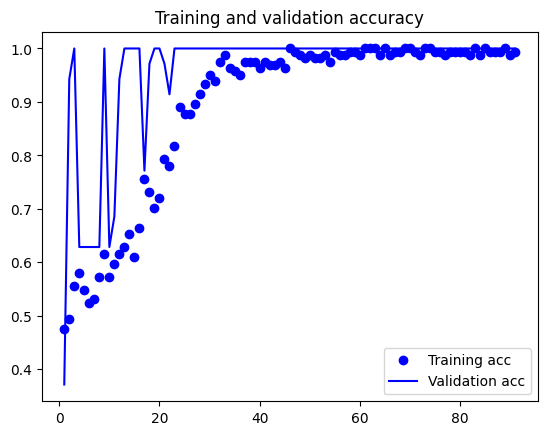

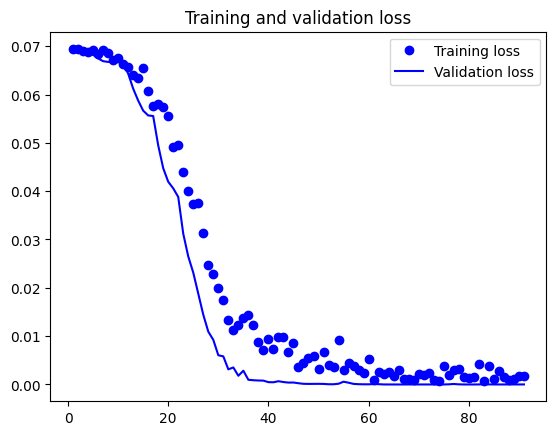

In [372]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#recall = history.history['recall_1']
#val_recall = history.history['val_recall_1']
#precision = history.history['precision_1']
#val_precision = history.history['val_precision_1']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()





In [373]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

2/2 - 0s - 37ms/step - accuracy: 1.0000 - loss: 1.8811e-05


In [374]:
# Save the model as a file
with open(os.getcwd() + '\\file.txt', 'w') as f:
  f.write(os.getcwd())

models.save_model(model, feature_sets_path + '\\' + model_filename)


In [375]:
print(feature_sets_path + '/' + model_filename)

c:\Users\Iman\Desktop\Stage\code/all_targets_1629_5369_8_8_8_16_16_32.h5


In [376]:
import seaborn as sns
import tensorflow as tf


In [377]:
y_true=y_train
#y_pred=model.predict_classes(x_test)
predict_y=model.predict(x_train)
y_pred=np.argmax(predict_y,axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


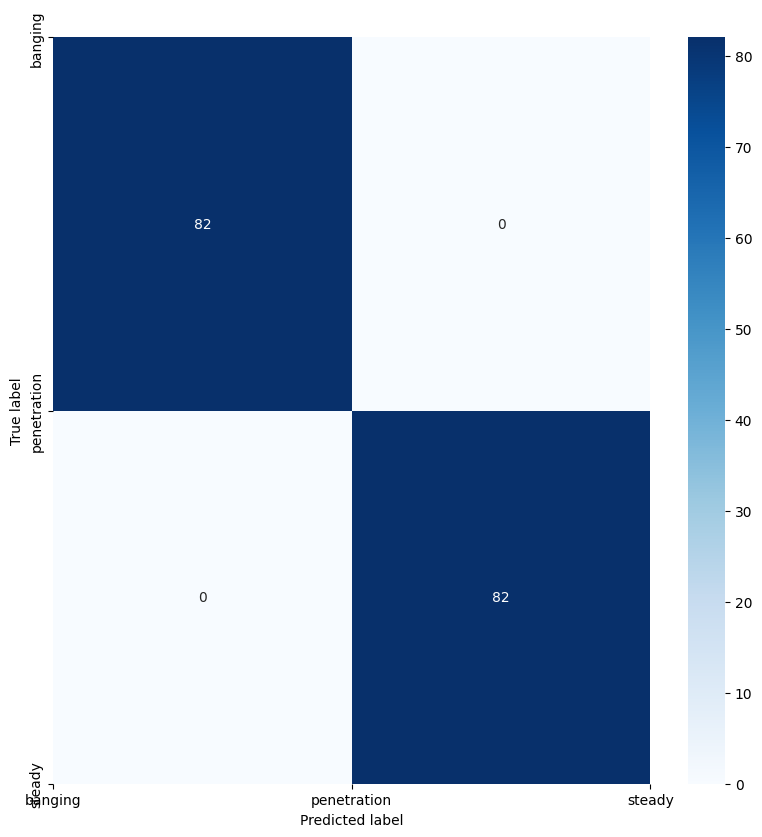

In [378]:
classes = [0,1]
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float')) #/ con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#ax = figure.add_axes([0, 6, 0, 6]) # main axes
plt.xticks([0,1,2],['banging', 'penetration','steady'])
plt.yticks([0,1,2],['banging', 'penetration','steady'])
#plt.xticks([0,1,2,3,4,5,6], ['closed', 'drill','opened', 'openingclosing', 'penetration', 'shake', 'shock'], rotation='vertical')
#plt.yticks([0,1,2,3,4,5,6], ['closed', 'drill','opened', 'openingclosing', 'penetration', 'shake', 'shock'], rotation='horizontal')
#ax.set_xlabels(['closed', 'drill','opened', 'openingclosing', 'penetration', 'shake', 'shock'])
#ax.set_xyabels(['closed', 'drill','opened', 'openingclosing', 'penetration', 'shake', 'shock'])
plt.show()

number of samples : 54
test samples shape : (127, 64, 4, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Class for sample 2 (0-idle, 1-presence) 
0 :  2.373043e-13 
1 :  1.0


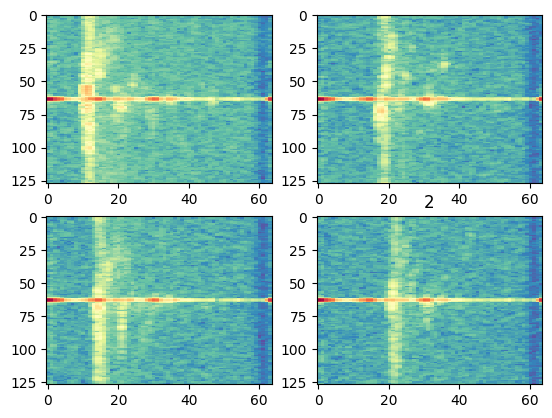

Predicted Class for sample 13 (0-idle, 1-presence) 
0 :  0.9986628 
1 :  0.0013372133


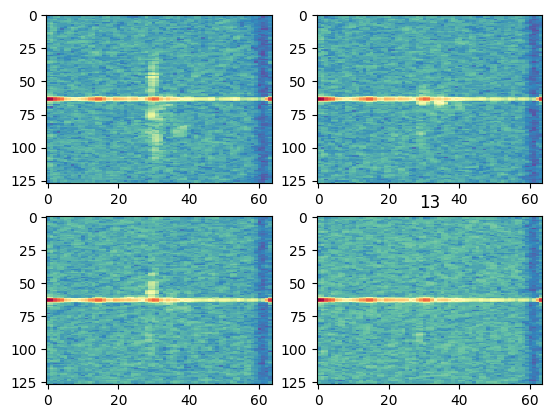

Predicted Class for sample 24 (0-idle, 1-presence) 
0 :  0.99775887 
1 :  0.0022410918


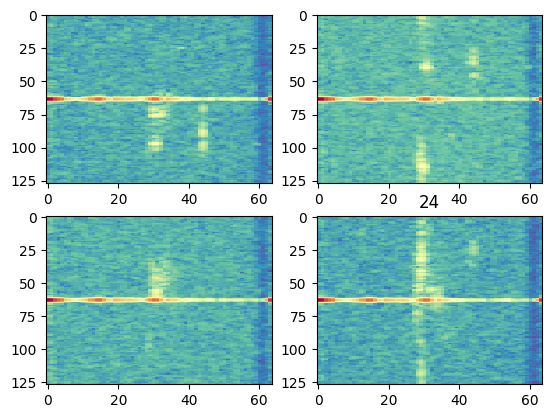

Predicted Class for sample 35 (0-idle, 1-presence) 
0 :  3.025305e-11 
1 :  1.0


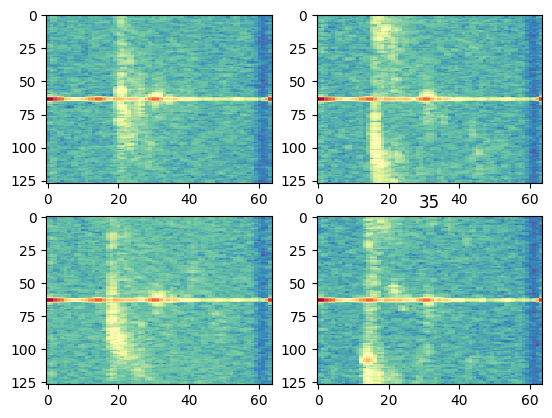

Predicted Class for sample 46 (0-idle, 1-presence) 
0 :  0.9998728 
1 :  0.00012714797


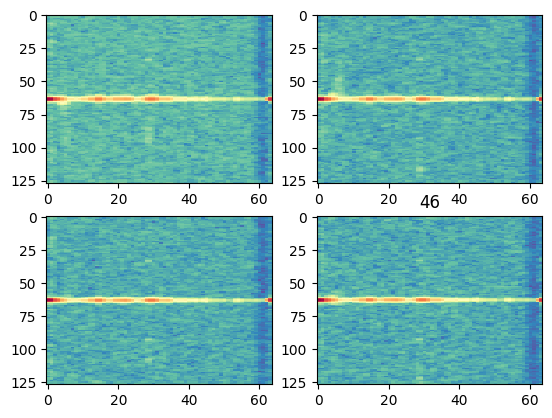

In [379]:
# Prediction test with unclassified parameters

# Load archive with the data to be predicted .npz
test_npz = np.load(os.getcwd()+'\\all_targets_1613_5350_test_classes_60.npz')
test_in = test_npz['x_test']                                  

test_in_reshape = test_in.reshape(int(test_in.shape[0]/(NUMBER_ROWS)),                  # Resize with sample shape
                          NUMBER_ROWS,
                          NUMBER_COlUMNS,
                          DEPTH,
                          1)

print('number of samples :',test_in_reshape.shape[0])
print('test samples shape :',test_in_reshape.shape[1:])

# Prediction on sample pack
label = model.predict(test_in_reshape)

# Loop throught the sample pack to display some of the predictions
for i in range (2,test_in_reshape.shape[0],11):
    print("Predicted Class for sample",i,"(0-idle, 1-presence) \n0 : ",label[i][0],"\n1 : ",label[i][1])    # Print predicted class
    sample = test_in[127*i:127*(i+1),:,:].reshape(
                          NUMBER_ROWS,
                          NUMBER_COlUMNS,
                          DEPTH)
    fig, subs = plt.subplots(2,2)
    for x in range(0,4,1): 
        f = sample[:,:,x]
        # read the csv file
        if (x < 2):
            subs[x][0].imshow(f, cmap='Spectral_r', interpolation='nearest', aspect='auto')
        else:
            subs[x-2][1].imshow(f, cmap='Spectral_r', interpolation='nearest', aspect='auto')
    plt.title(i)
    plt.show()

# for testing batch, should be : [1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]